In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from sklearn.utils import class_weight
from tensorflow.keras.applications.vgg16 import preprocess_input

In [19]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [20]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [21]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    plt.savefig('/home/jovyan/img2.png')
    plt.show()
   
    
    return fig

In [22]:
def loadImages(path_data, path_labels):

    feat_list = []
    

    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        feat_list.append(np.load(filename))

    x_orig = np.reshape(feat_list, (len(feat_list),35, 64))
    
    path = path_labels     
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [23]:
p_feat = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/LST_vs_CNN/ADR_HRH/'

train_data = p_feat + 'features_train/*.npy'
train_lab= p_feat + 'lstm_train.csv'

val_data = p_feat + 'features_validation/*.npy'
val_lab = p_feat + 'lstm_validation.csv'


test_data= p_feat + 'features_test/*.npy'
test_lab= p_feat + 'lstm_test.csv'

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [25]:
x_train, y_train = loadImages(train_data, train_lab)
x_train.shape, y_train.shape

((1582, 35, 64), (1582,))

In [26]:
x_val, y_val = loadImages(val_data, val_lab)
x_val.shape, y_val.shape

((419, 35, 64), (419,))

In [27]:
x_test, y_test = loadImages(test_data, test_lab)
x_test.shape, y_test.shape

((518, 35, 64), (518,))

In [28]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 913, 1: 669}

In [29]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
print('weights = ' + str(weights))

weights = [0.86637459 1.18236173]


In [38]:
m = Sequential()
m.add(LSTM(64, input_shape = (x_train.shape[1],x_train.shape[2])))
m.add(Dropout(0.2))
m.add(Dense(1, activation='sigmoid'))
m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 33,089
Trainable params: 33,089
Non-trainable params: 0
_________________________________________________________________


In [39]:
opt = keras.optimizers.Adam(lr=1e-4)

m.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])


In [40]:
epochs = 300

m4_h = m.fit(x_train,y_train,
                 
                 callbacks = [es],
                
                epochs=epochs,
                validation_data = (x_val,y_val), 
                
                class_weight = weights)

Train on 1582 samples, validate on 419 samples
Epoch 1/300
1582/1582 [==============================] - 2s 1ms/sample - loss: 0.6180 - accuracy: 0.6757 - val_loss: 0.6345 - val_accuracy: 0.6277
Epoch 2/300
1582/1582 [==============================] - 0s 216us/sample - loss: 0.5147 - accuracy: 0.8097 - val_loss: 0.6081 - val_accuracy: 0.6659
Epoch 3/300
1582/1582 [==============================] - 0s 201us/sample - loss: 0.3944 - accuracy: 0.8786 - val_loss: 0.6133 - val_accuracy: 0.6802
Epoch 4/300
1582/1582 [==============================] - 0s 228us/sample - loss: 0.2652 - accuracy: 0.9178 - val_loss: 0.6841 - val_accuracy: 0.6730
Epoch 5/300
1582/1582 [==============================] - 0s 242us/sample - loss: 0.1959 - accuracy: 0.9298 - val_loss: 0.7629 - val_accuracy: 0.6778
Epoch 6/300
1582/1582 [==============================] - 0s 260us/sample - loss: 0.1687 - accuracy: 0.9387 - val_loss: 0.8081 - val_accuracy: 0.6921
Epoch 7/300
1582/1582 [==============================] - 0s 2

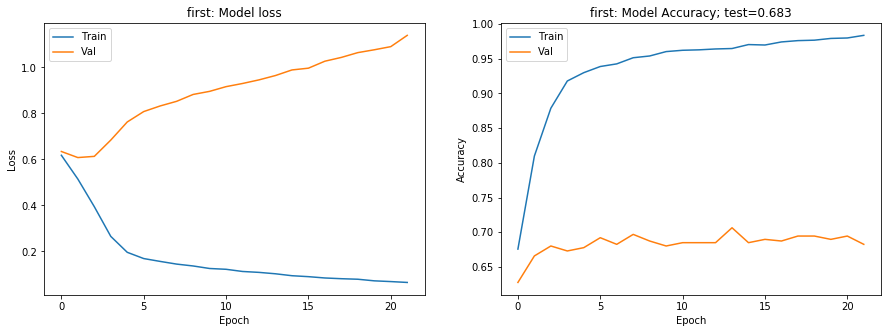

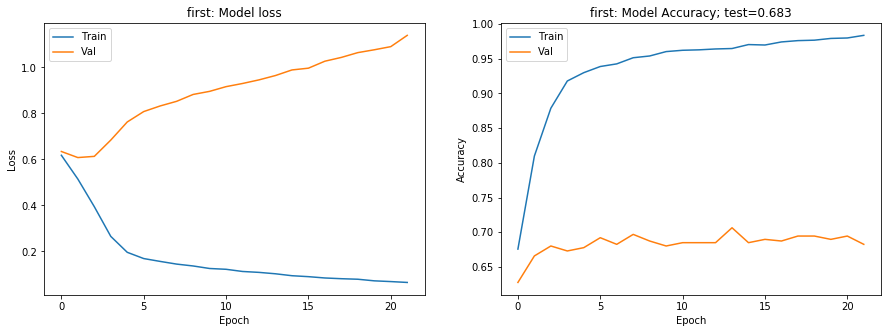

In [41]:
plot_history(m4_h, 'first')

In [42]:
scores = m.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

518/518 [==============================] - 0s 136us/sample - loss: 1.0736 - accuracy: 0.7104

accuracy: 71.04%


# For Binary Classification

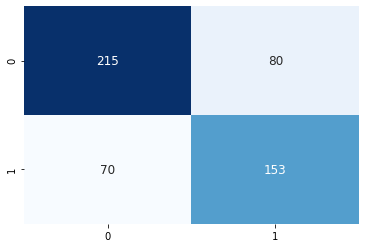

array([[215,  80],
       [ 70, 153]])

In [43]:
test_preds = m.predict(x_test)

t= []
for i in (test_preds):
    if i > 0.5:
        t.append(1)
    else:
        t.append(0)

draw_confusion_matrix(y_test, t)

In [44]:
print(classification_report(y_test, t))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       295
           1       0.66      0.69      0.67       223

    accuracy                           0.71       518
   macro avg       0.71      0.71      0.71       518
weighted avg       0.71      0.71      0.71       518

